In [64]:
from __future__ import division, print_function
import os
import sys
import numpy as np
import pandas as pd
import src.preprocessing as preprocessing
from src.preprocessing import preprocess, preprocess_players
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.preprocessing import PolynomialFeatures
from src.build_db import connect
from src.db_helpers import parse_date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from scipy.sparse import coo_matrix, csc_matrix, hstack
warnings.filterwarnings("ignore")

In [2]:
# connect to opendota
db_name = 'opendota'
with open(os.path.expanduser('~/.pgpass')) as f:
    for line in f:
        host, port, db, user, password = [x.strip() for x in line.split(':')]
        if db == db_name:
            opendota_con, meta = connect(user=user, password=password, db=db, host=host, port=port)
            break
            
# connect to db
db_name = 'dota_db'
with open(os.path.expanduser('~/.pgpass')) as f:
    for line in f:
        host, port, db, user, password = [x.strip() for x in line.split(':')]
        if db == db_name:
            dota_con, meta = connect(user=user, password=password, db=db, host=host, port=port)
            break

In [3]:
start_date = parse_date('2016-12-12')
query = '''SELECT m.match_id as match_id,
            m.picks_bans as picks_bans,
            m.radiant_win as radiant_win
            FROM matches as m
            JOIN start_times as st
            ON st.match_id = m.match_id
            WHERE --st.start_time >={} AND
            duration >= 600;'''.format(start_date)
opendota_df = pd.read_sql(query , opendota_con)
opendota_df = preprocess(opendota_df)

In [4]:
query = '''
SELECT match_id, players, radiant_win FROM matches WHERE duration >= 600;
'''
recent_df = pd.read_sql(query, dota_con)
recent_df = preprocess_players(recent_df)

In [3]:
query = '''
SELECT DISTINCT ON(match_id) match_id, players, radiant_win FROM match_history WHERE duration >= 600;
'''
high_skill_df = pd.read_sql(query, dota_con)
high_skill_df = preprocess_players(high_skill_df)

In [10]:
high_skill_df.shape

(65812, 230)

In [4]:
y_hs = high_skill_df['radiant_win'].values
X_hs = high_skill_df.drop(['radiant_win', 'match_id'], axis=1).values

In [13]:
X_r = recent_df.drop(['match_id', 'radiant_win'], axis=1)
y_r = recent_df['radiant_win'].values

X_od = opendota_df.drop(['team1_win', 'match_id'], axis=1)
y_od = opendota_df['team1_win'].values

# Learning Rates

##### Logistic Regression

In [6]:
train_sizes, train_scores, log_test_scores = learning_curve(LogisticRegression(), X_hs, y_hs, train_sizes=[.01, .05, .1, .2, .4, .6, .9])

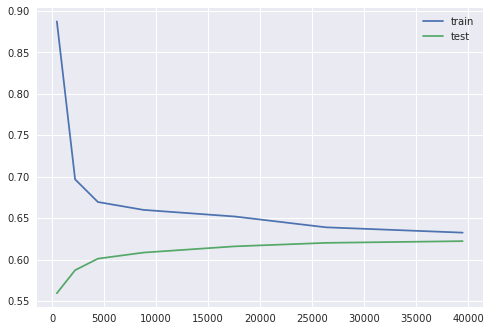

In [31]:
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='train')
plt.plot(train_sizes, np.mean(log_test_scores, axis=1), label='test')
plt.legend()
plt.show()

##### Ridge Regression

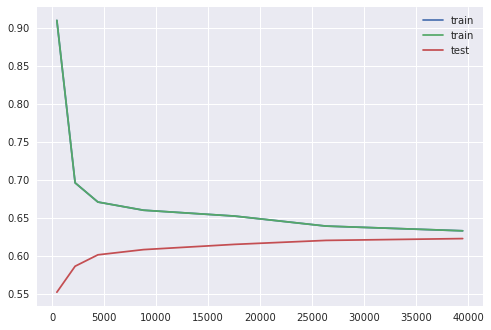

In [8]:
train_sizes, train_scores, ridge_test_scores = learning_curve(RidgeClassifier(), X_hs, y_hs, train_sizes=[.01, .05, .1, .2, .4, .6, .9])
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='train')
plt.plot(train_sizes, np.mean(ridge_test_scores, axis=1), label='test')
plt.legend()
plt.show()

##### Bagged Logistic Regression

In [9]:
train_sizes, train_scores, bagged_test_scores = learning_curve(BaggingClassifier(), X_hs, y_hs, train_sizes=[.01, .05, .1, .2, .4, .6, .9])
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='train')
plt.plot(train_sizes, np.mean(bagged_test_scores, axis=1), label='test')
plt.legend()
plt.show()

NameError: name 'test_scores' is not defined

In [11]:
train_sizes, train_scores, rf_test_scores = learning_curve(RandomForestClassifier(), X_hs, y_hs, train_sizes=[.01, .05, .1, .2, .4, .6, .9])

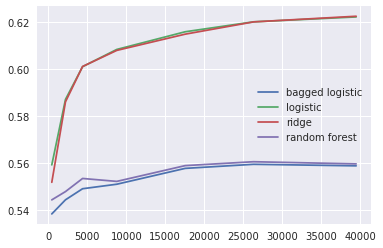

In [24]:
%matplotlib inline
fig, ax = plt.subplots()
bagged_line = ax.plot(train_sizes, np.mean(bagged_test_scores, axis=1), label='bagged logistic')[0]
log_line = ax.plot(train_sizes, np.mean(log_test_scores, axis=1), label='logisitic')[0]
ridge_line = ax.plot(train_sizes, np.mean(ridge_test_scores, axis=1), label='ridge')[0]
rf_line = ax.plot(train_sizes, np.mean(rf_test_scores, axis=1), label='random forest')[0]
ax.legend([bagged_line, log_line, ridge_line, rf_line], ['bagged logistic', 'logistic', 'ridge', 'random forest'])

In [37]:
cross_val_score(GaussianNB(), X_hs, y_hs, cv=5).mean()

0.59106244965490773

In [37]:
pca = PCA(n_components=.75, svd_solver='full')
X_pca = pca.fit_transform(X_hs)

In [38]:
X_pca.shape

(65812, 115)

In [39]:
cross_val_score(LogisticRegression(), X_pca, y_hs, cv=5).mean()

0.61034447156007077

In [40]:
cross_val_score(RandomForestClassifier(), X_hs, y_hs, cv=5).mean()

0.55549144128048122

In [43]:
nmf = NMF(n_components=150)
X_nmf = nmf.fit_transform(X_hs)

In [44]:
X_nmf.shape

(65812, 150)

In [45]:
cross_val_score(LogisticRegression(), X_nmf, y_hs, cv=5).mean()

0.6150853104497247

In [46]:
cross_val_score(RandomForestClassifier(), X_nmf, y_hs, cv=5).mean()

0.54561474334206594

In [5]:
cross_val_score(LogisticRegression(), X_hs, y_hs, cv=5).mean()

0.62418702823446603

# Polynomial Features

In [24]:
X_sparse = csc_matrix(X_hs)
#pf = PolynomialFeatures(interaction_only=True, include_bias=False)
#X_poly = pf.fit_transform(X_sparse)
sparse_product = []
for i in xrange(X_hs.shape[1] -1 ):
    for j in xrange(i, X_hs.shape[1]):
        sparse_product.append(X_sparse[:, i].multiply(X_sparse[:, j]))
X_sparse_poly = hstack(sparse_product)

In [27]:
X_sparse.count_nonzero()

658120

In [33]:
cross_val_score(RidgeClassifier(alpha=2.0), X_sparse_poly, y_hs, cv=5).mean()

0.56977437878131454

In [36]:
cross_val_score(RidgeClassifier(alpha=10.0), X_sparse_poly, y_hs, cv=5).mean()

0.58180871000674539

In [45]:
cross_val_score(RidgeClassifier(alpha=1000.0), X_sparse_poly, y_hs, cv=5).mean()

0.62860870779982803

In [46]:
cross_val_score(LogisticRegression(), X_sparse, y_hs, cv=5).mean()

0.62418702823446603

In [52]:
tsvd = TruncatedSVD(n_components=100)
X_pca_poly = tsvd.fit_transform(X_sparse_poly)

In [53]:
cross_val_score(LogisticRegression(), X_pca_poly, y_hs, cv=5).mean()

0.61052693935228031

In [55]:
cross_val_score(RandomForestClassifier(), X_pca_poly, y_hs, cv=5).mean()

0.53476562038996289

In [61]:
cross_val_score(BernoulliNB(), X_hs, y_hs).mean()

0.62131529743538005

In [66]:
vc = VotingClassifier(estimators=[('rc', RidgeClassifier(alpha=1000)),
                                  ('lr', LogisticRegression()),
                                  ('bern', BernoulliNB())], n_jobs=-1)
cross_val_score(vc, X_sparse_poly, y_hs, cv=5).mean()

OSError: [Errno 12] Cannot allocate memory